# Stitch individual tif files into whole-slide images

Stitcing in scPortrait is built on top of the [Ashlar](https://labsyspharm.github.io/ashlar/) package.

When stitching from `.tif` files, Ashlar reads channel and tile position information from filenames according to a predefined `pattern`. Hence, filenames matter when stitching from `.tif` files.

In [1]:
import os

os.environ["JAVA_HOME"] = "/Users/sophia/mambaforge/envs/scPortrait/lib/jvm"
import matplotlib.pyplot as plt

from scportrait.data._datasets import dataset_stitching_example
from scportrait.tools.stitch import ParallelStitcher, Stitcher

/Users/sophia/mambaforge/envs/scportrait_new/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/Users/sophia/mambaforge/envs/scportrait_new/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Single-threaded Stitching

### Initializing the `Stitcher` object

In [ ]:
input_dir = dataset_stitching_example()
slidename = "stitching_test"
outdir = os.path.join(str(input_dir).replace("stitching_example", "example_projects/stitching"), slidename)

row = str(2).zfill(2)  # specify the row of the well you want to stitch, here = 2
well = str(4).zfill(2)  # specifc the well number you wish to stitch, here = 4
zstack_value = str(1).zfill(
    3
)  # specify the zstack you want to stitch. for multiple zstacks please make a loop and iterate through each of them.
timepoint = str(1).zfill(3)  # specify the timepoint you wish to stitch

pattern = f"Timepoint{timepoint}_Row{row}_Well{well}_{{channel}}_zstack{zstack_value}_r{{row:03}}_c{{col:03}}.tif"

# initialize stitcher
stitcher = Stitcher(
    os.path.abspath(input_dir),
    slidename,
    outdir,
    pattern=pattern,
    stitching_channel="Alexa488",
    channel_order=[
        "DAPI",
        "Alexa488",
        "mCherry",
    ],  # this can be used to override the order of channels in the final stitched image for image types like ome.zarr, if not specified alphabetical order is used
    overlap=0.1,
    max_shift=30,
    filter_sigma=0,
    rescale_range={"Alexa488": (1, 99), "DAPI": (1, 99), "mCherry": (1, 99)},
    overwrite=True,
)

Output directory at /Users/sophia/Documents/GitHub/scPortrait/scportrait_data/example_projects/stitching/stitching_test already exists, overwriting.


You can access information on which channels are present in your dataset and the specific values of the parameters relevant to stitching by executing:

In [22]:
stitcher.get_stitching_information()

Tile positions will be calculated based on channel: Alexa488
Channel Names: ['Alexa488', 'DAPI', 'mCherry']
Overlap of image tiles: 0.1
Max Shift value: 30
Filter Sigma value: 0
Output will be written to: /Users/sophia/Documents/GitHub/scPortrait/scportrait_data/example_projects/stitching/stitching_test


### Generating thumbnails

In [3]:
stitcher.generate_thumbnail()

    assembling thumbnail 9/9


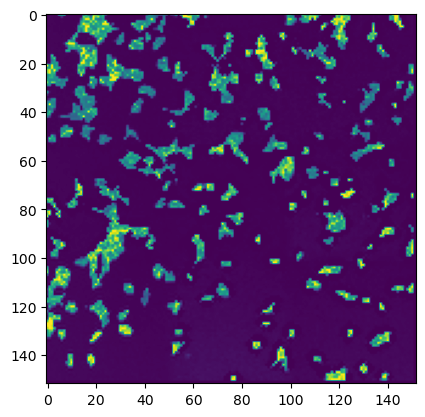

In [4]:
# thumbnail is saved in the stitcher object and can be accessed via stitcher.thumbnail
plt.imshow(stitcher.thumbnail)

In [5]:
# alterantively it can be saved to a tif file
stitcher.write_thumbnail()

### Generating full-scale stitched image

performing stitching on channel Alexa488 with id number 0
    quantifying alignment error 1000/1000
    aligning edge 12/12


Alignment complete.
assembling mosaic with shape (3, 3040, 3038)
created tempmmap array for assembled mosaic at /Users/sophia/Documents/GitHub/scPortrait/scportrait_data/example_projects/stitching/stitching_test/temp_mmap_zhxh9_b2/temp_mmap_267690355536480897.hdf


  0%|          | 0/3 [00:00<?, ?it/s]

        merging tile 9/9

 33%|███▎      | 1/3 [00:01<00:02,  1.06s/it]


        merging tile 9/9

 67%|██████▋   | 2/3 [00:02<00:01,  1.06s/it]


        merging tile 9/9

100%|██████████| 3/3 [00:03<00:00,  1.06s/it]

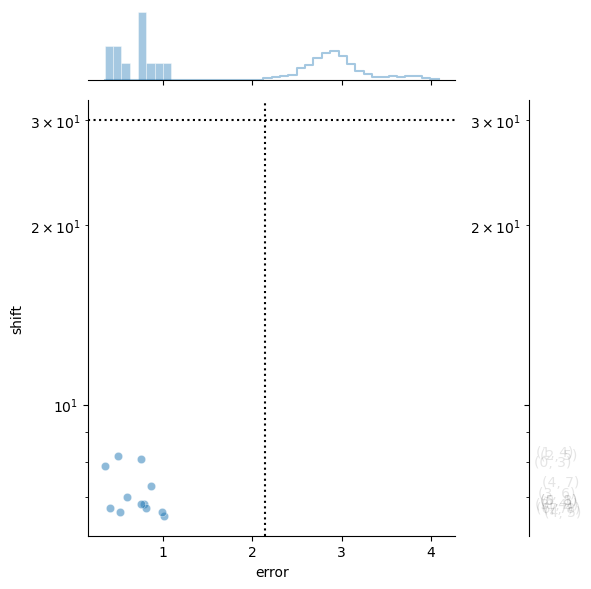

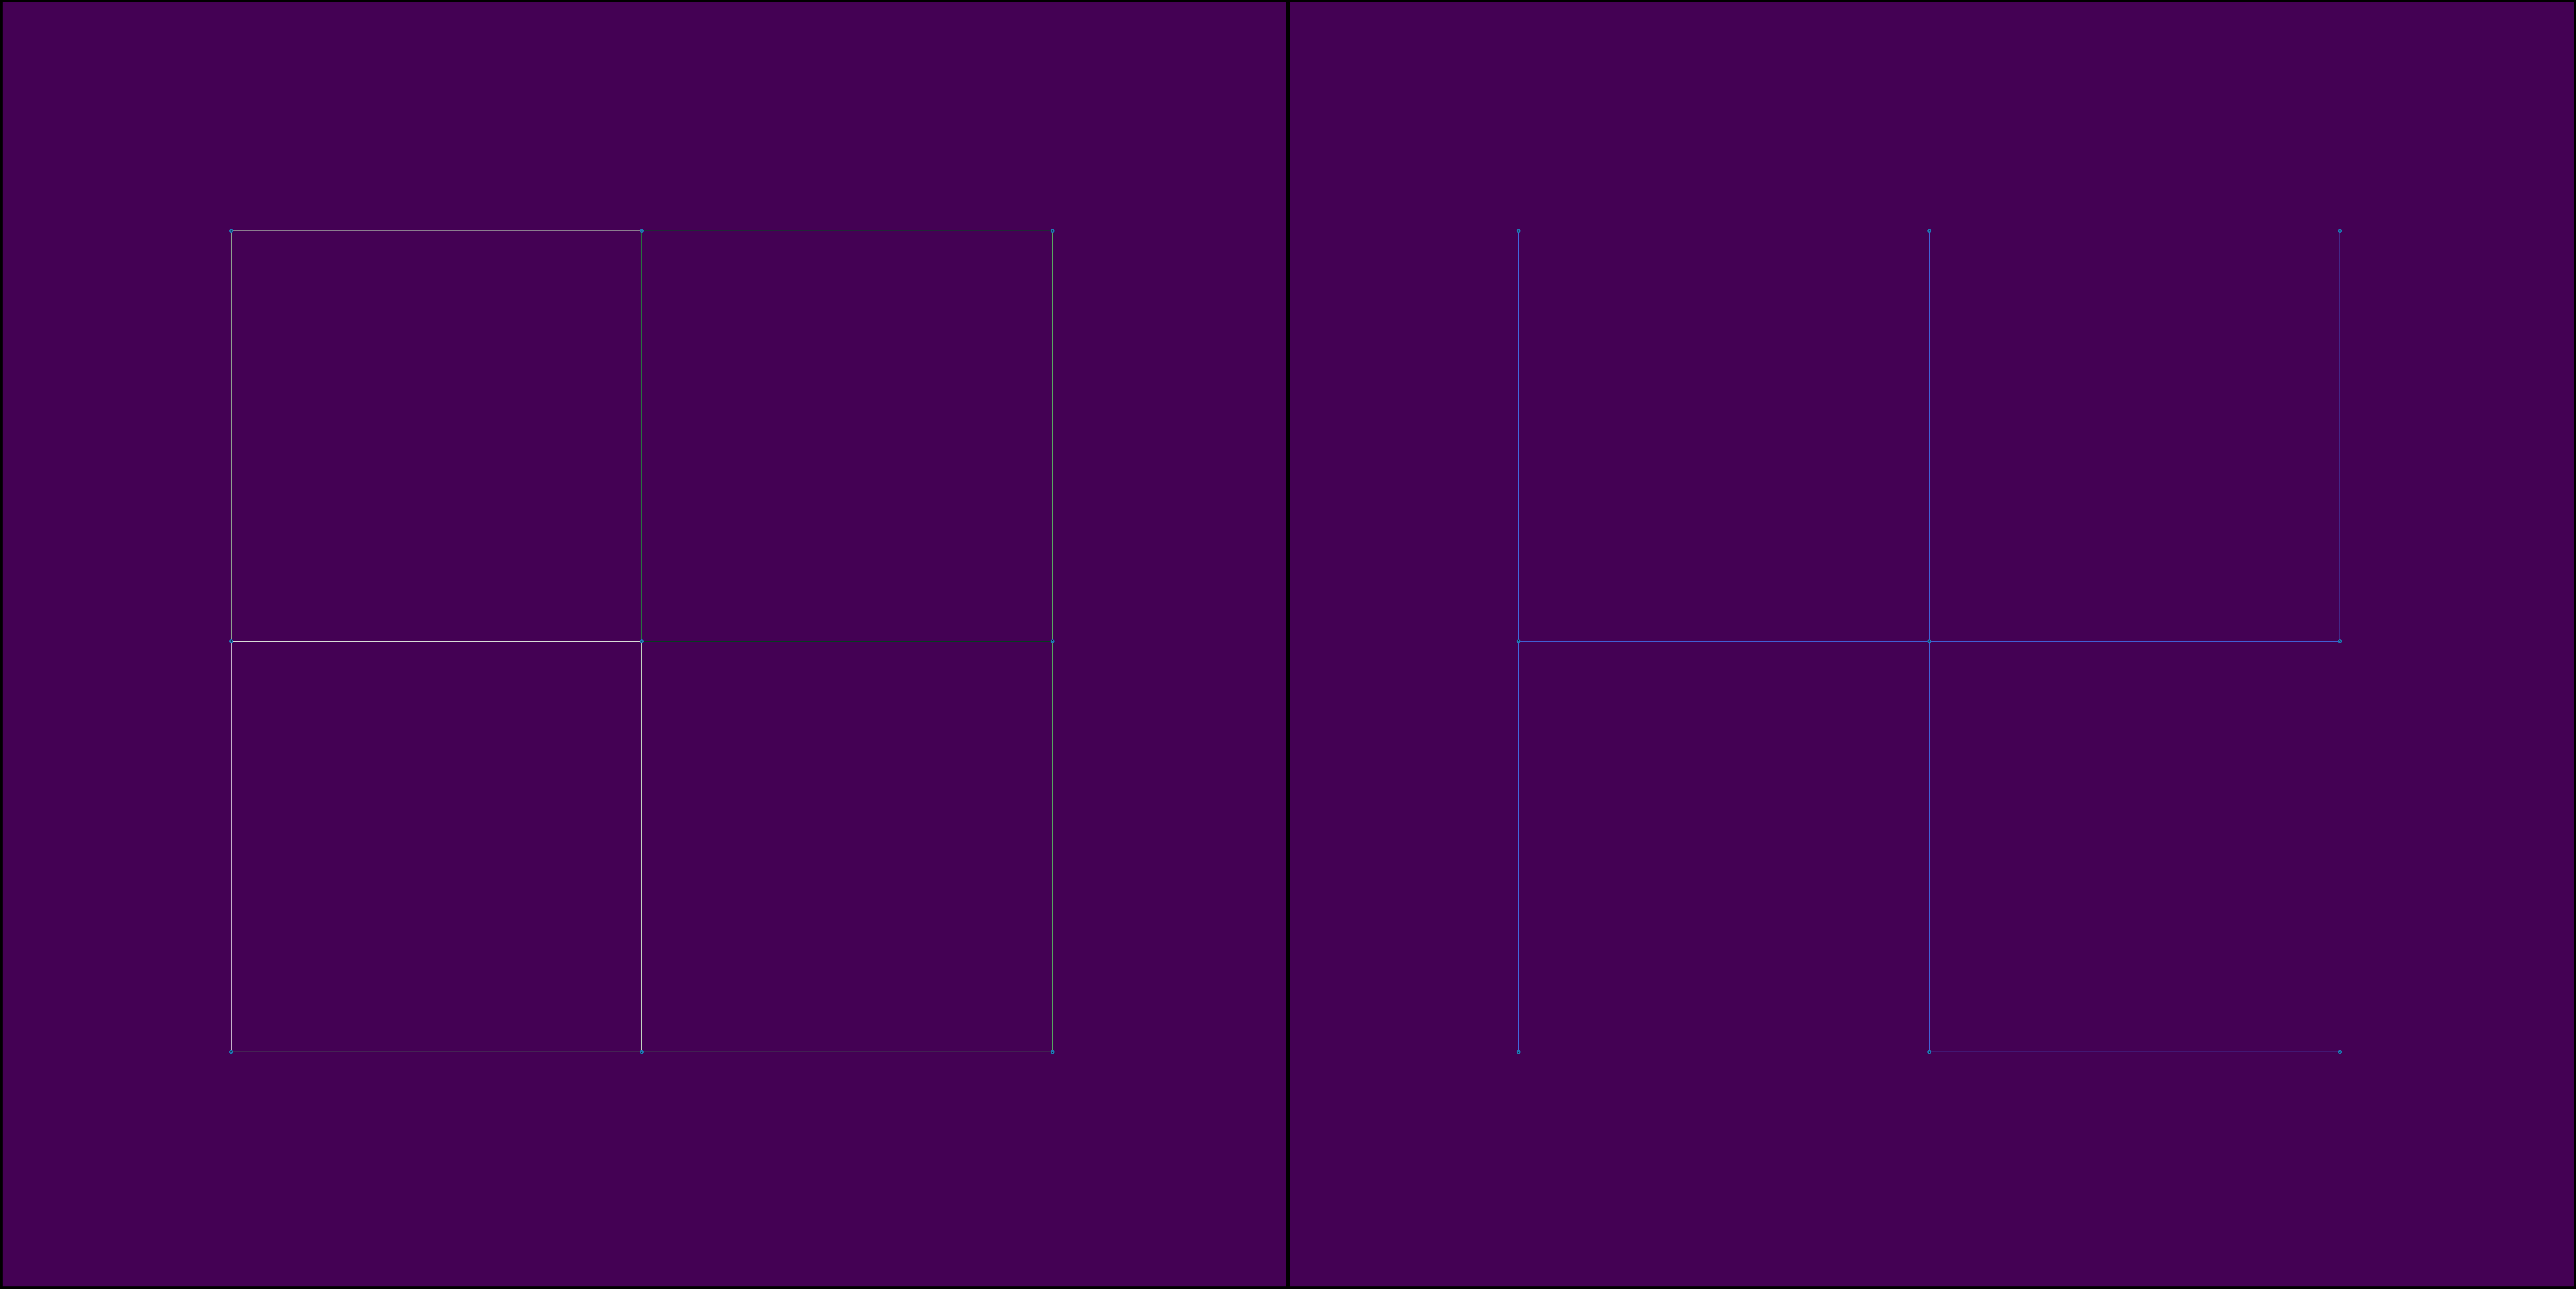

In [6]:
stitcher.stitch()

In [7]:
# the stitched image is saved in the stitcher object and can be accessed via stitcher.assembled_mosaic
stitcher.assembled_mosaic

dask.array<from-value, shape=(3, 3040, 3038), dtype=uint16, chunksize=(3, 3040, 3038), chunktype=numpy.ndarray>

In [8]:
# the stitched image can then be written to a variety of output formats

stitcher.write_tif(export_xml=True)
stitcher.write_ome_zarr()

(-0.5, 3037.5, 3039.5, -0.5)

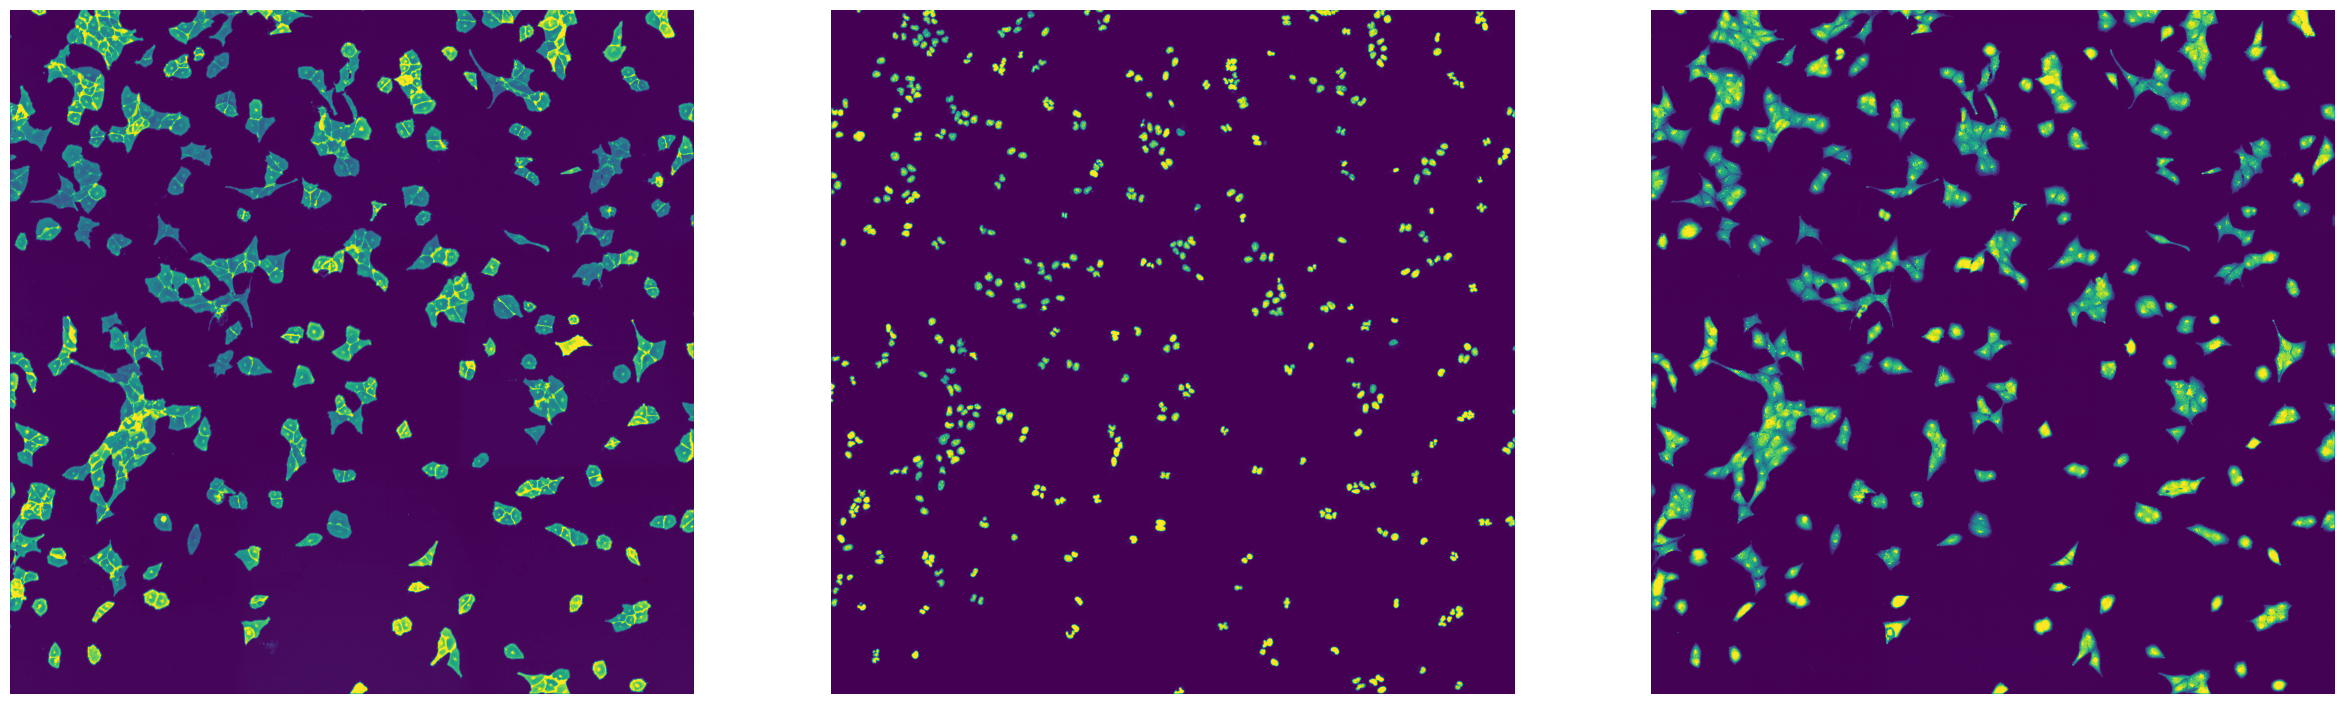

In [9]:
import matplotlib.pyplot as plt
from tifffile import imread

fig, axs = plt.subplots(1, 3, figsize=(30, 10))
axs[0].imshow(imread(f"{outdir}/stitching_test_Alexa488.tif"))
axs[0].axis("off")

axs[1].imshow(imread(f"{outdir}/stitching_test_DAPI.tif"))
axs[1].axis("off")

axs[2].imshow(imread(f"{outdir}/stitching_test_mCherry.tif"))
axs[2].axis("off")

In [10]:
del stitcher

## Multi-threaded Stitching

The `ParallelStitcher` class can speed up stitching by using multiple threads. The code to start stitching remains the same, but `ParallelStitcher` takes an additional argument `threads`, specifying the number of parallel threads to use. This multi-threaded implementation uses some of ashlars base functionality but implements custom functions for several processing steps.

### Initializing the `ParallelStitcher` object

In [11]:
input_dir = dataset_stitching_example()
slidename = "stitching_test_parallel"
outdir_parallel = os.path.join(str(input_dir).replace("stitching_example", "example_projects/stitching"), slidename)


row = str(2).zfill(2)  # specify the row of the well you want to stitch, here = 2
well = str(4).zfill(2)  # specifc the well number you wish to stitch, here = 4
zstack_value = str(1).zfill(
    3
)  # specify the zstack you want to stitch. for multiple zstacks please make a loop and iterate through each of them.
timepoint = str(1).zfill(3)  # specify the timepoint you wish to stitch

pattern = f"Timepoint{timepoint}_Row{row}_Well{well}_{{channel}}_zstack{zstack_value}_r{{row:03}}_c{{col:03}}.tif"

# initialize stitcher
stitcher = ParallelStitcher(
    input_dir,
    slidename,
    outdir_parallel,
    pattern=pattern,
    stitching_channel="Alexa488",
    channel_order=["DAPI", "Alexa488", "mCherry"],
    overlap=0.1,
    max_shift=30,
    filter_sigma=0,
    rescale_range={"Alexa488": (1, 99), "DAPI": (1, 99), "mCherry": (1, 99)},
    overwrite=True,
    threads=12,
)

Output directory at /Users/sophia/Documents/GitHub/scPortrait/scportrait_data/example_projects/stitching/stitching_test_parallel already exists, overwriting.


### Generating thumbnails

In [12]:
stitcher.generate_thumbnail()

    assembling thumbnail 9/9


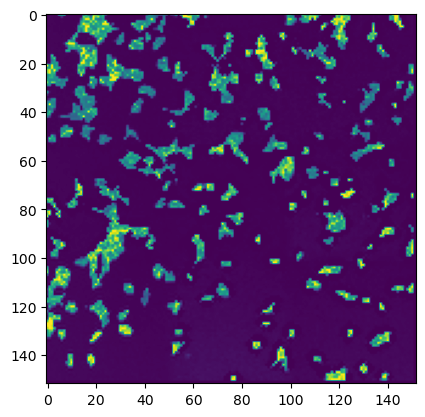

In [13]:
# thumbnail is saved in the stitcher object and can be accessed via stitcher.thumbnail
plt.imshow(stitcher.thumbnail)

In [14]:
# alterantively it can be saved to a tif file
stitcher.write_thumbnail()

### Generating full-scale stitched image

performing stitching on channel Alexa488 with id number 0
                  aligning edge: 100%|██████████| 12/12 [00:00<00:00, 451.91it/s]
using graph-tool to build spanning tree


Alignment complete.
current channel order:  [0, 1, 2]
new channel order [1, 0, 2]
assembling mosaic with shape (3, 3040, 3038)
created tempmmap array for assembled mosaic at /Users/sophia/Documents/GitHub/scPortrait/scportrait_data/example_projects/stitching/stitching_test_parallel/temp_mmap_yq7657gu/temp_mmap_2248175831853828840.hdf
assembling channels with 3 workers
assembling mosaic:   0%|          | 0/3 [00:00<?, ?it/s]



























assembling mosaic:  33%|███▎      | 1/3 [00:01<00:02,  1.20s/it]

assembling mosaic: 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]


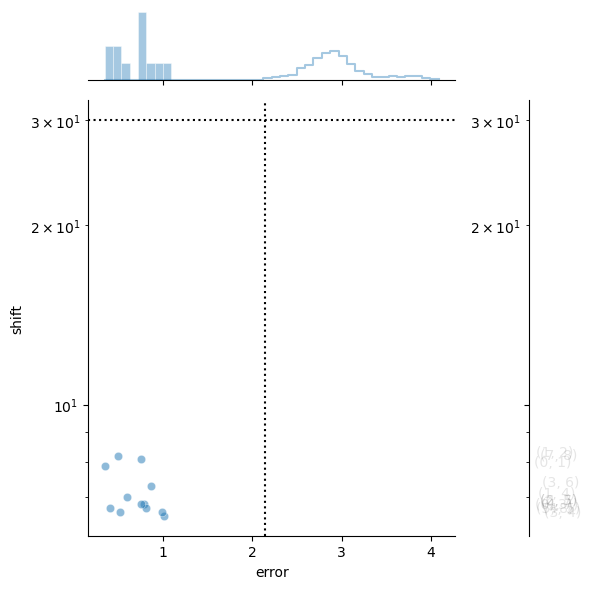

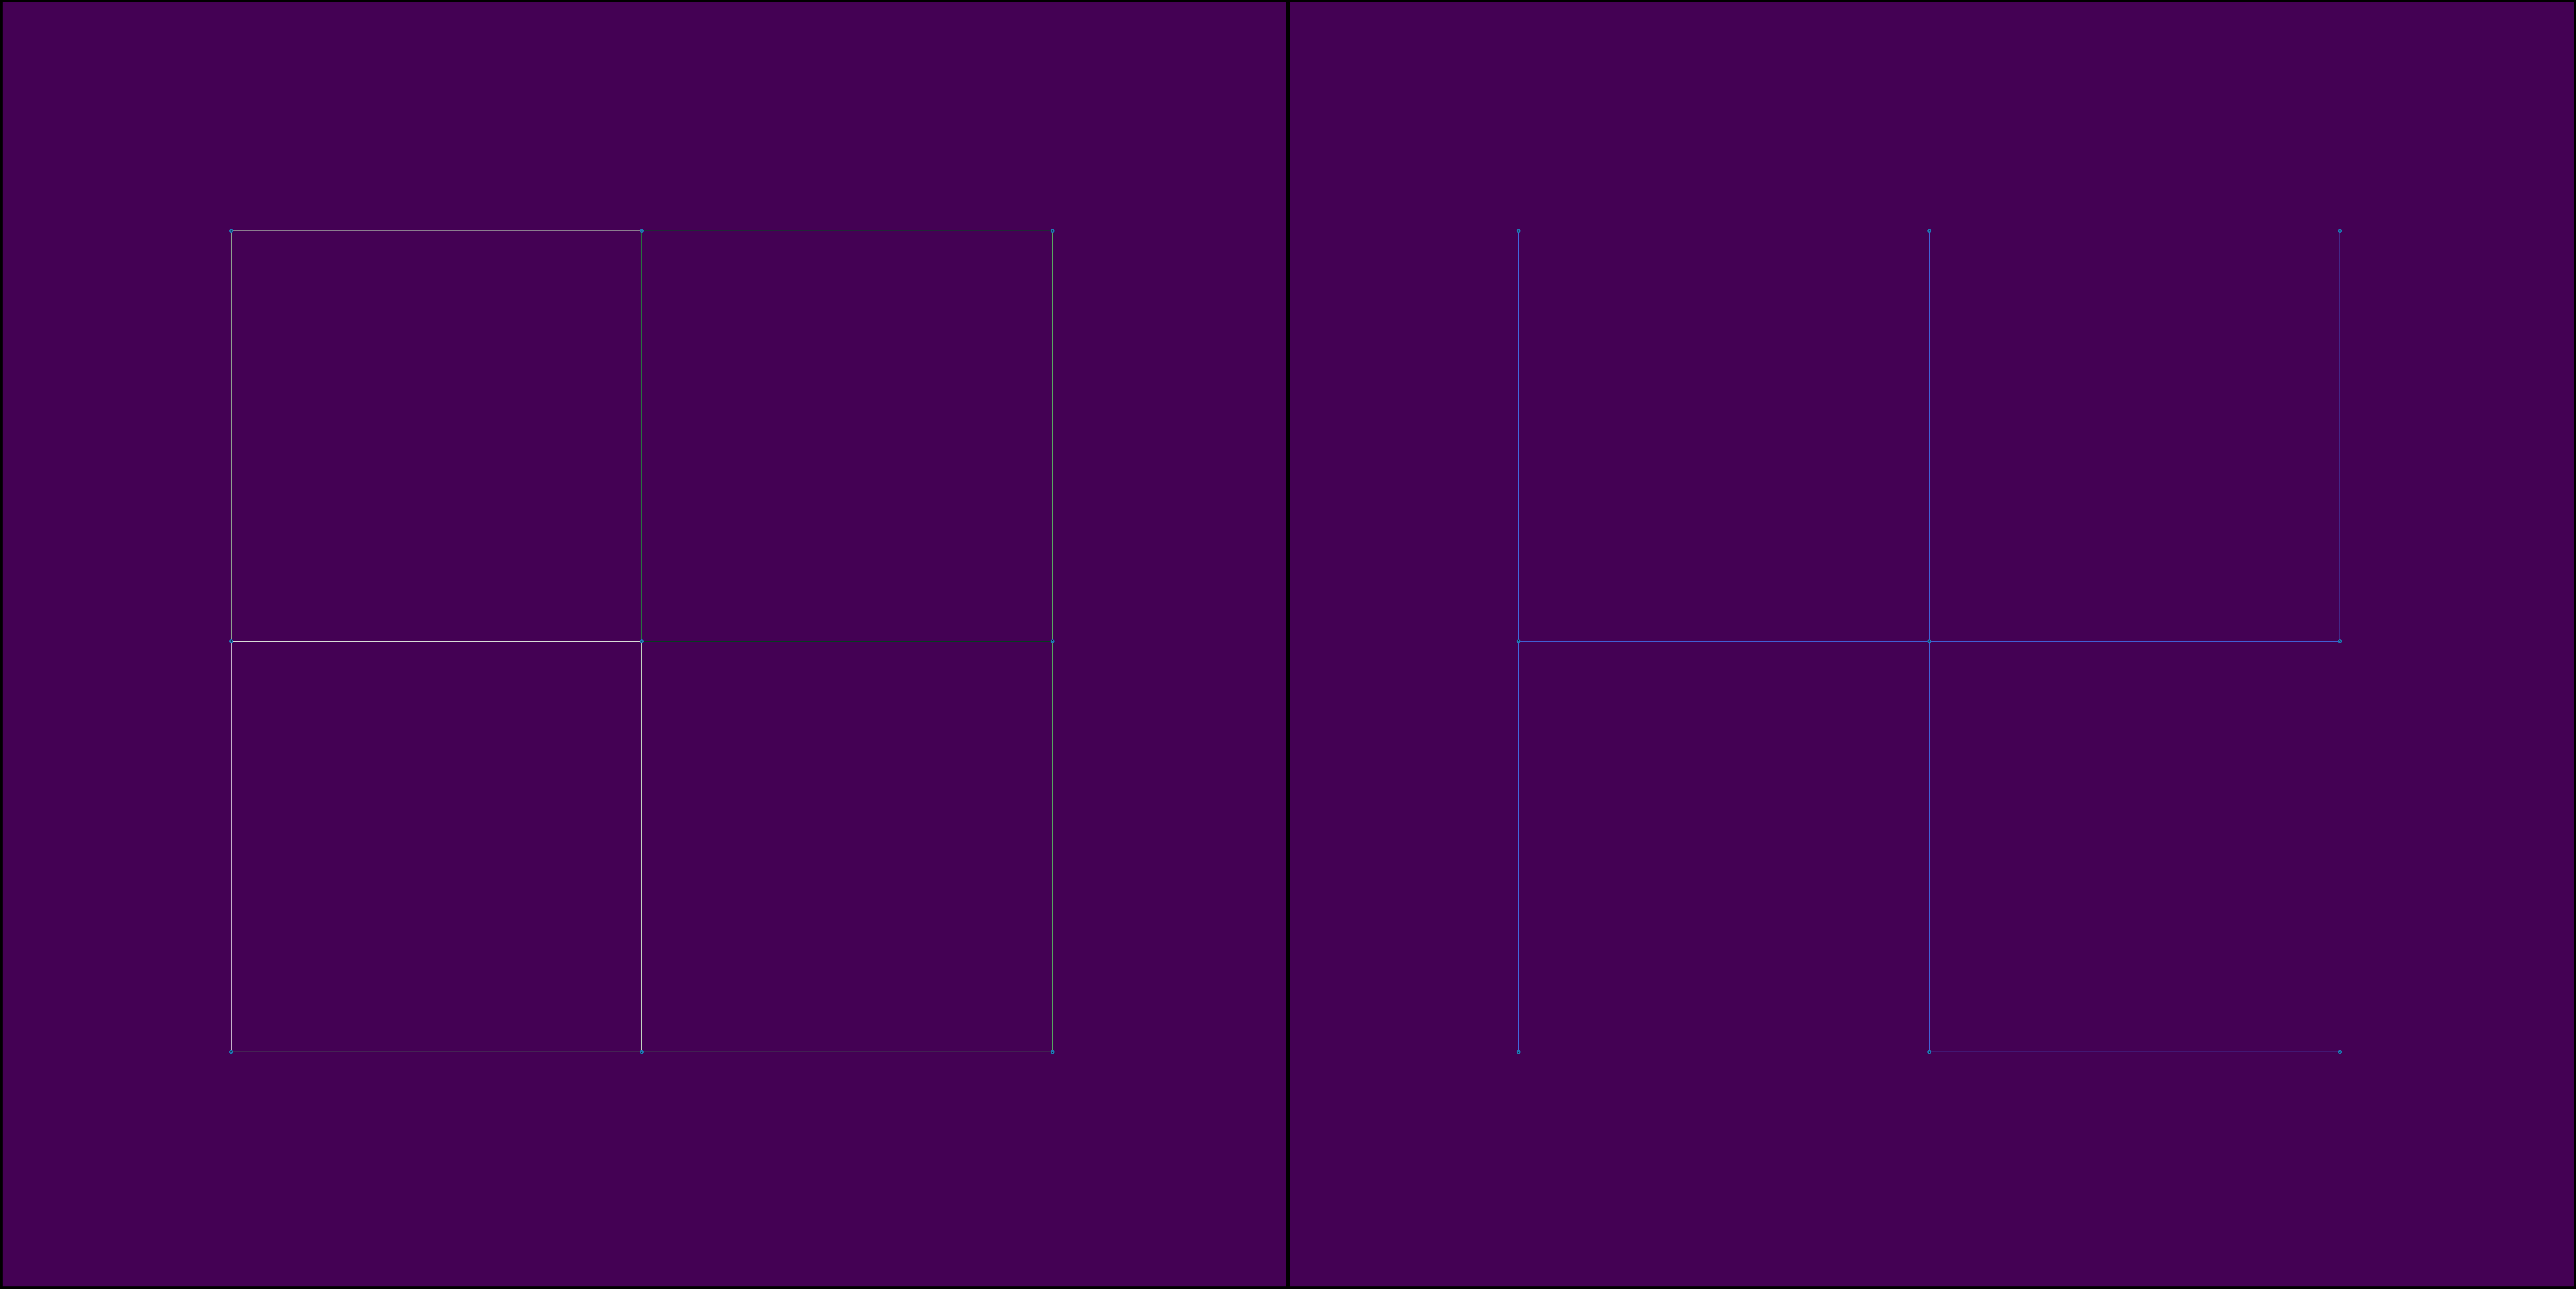

In [15]:
stitcher.stitch()

In [16]:
# the stitched image is saved in the stitcher object and can be accessed via stitcher.assembled_mosaic
stitcher.assembled_mosaic

dask.array<from-value, shape=(3, 3040, 3038), dtype=uint16, chunksize=(3, 3040, 3038), chunktype=numpy.ndarray>

In [17]:
# the stitched image can then be written to a variety of output formats

stitcher.write_tif(export_xml=True)

# alternatively the stitched images can also be written out to tifs in a multi-threaded format
# speedups here are limited by write speed to disk, the number of threads is limited by the number of channels available
stitcher.write_tif_parallel(export_xml=True)

stitcher.write_ome_zarr()

writing tif files: 100%|██████████| 3/3 [00:00<00:00, 221.21it/s]


## Visualize Stitching Output

(-0.5, 3037.5, 3039.5, -0.5)

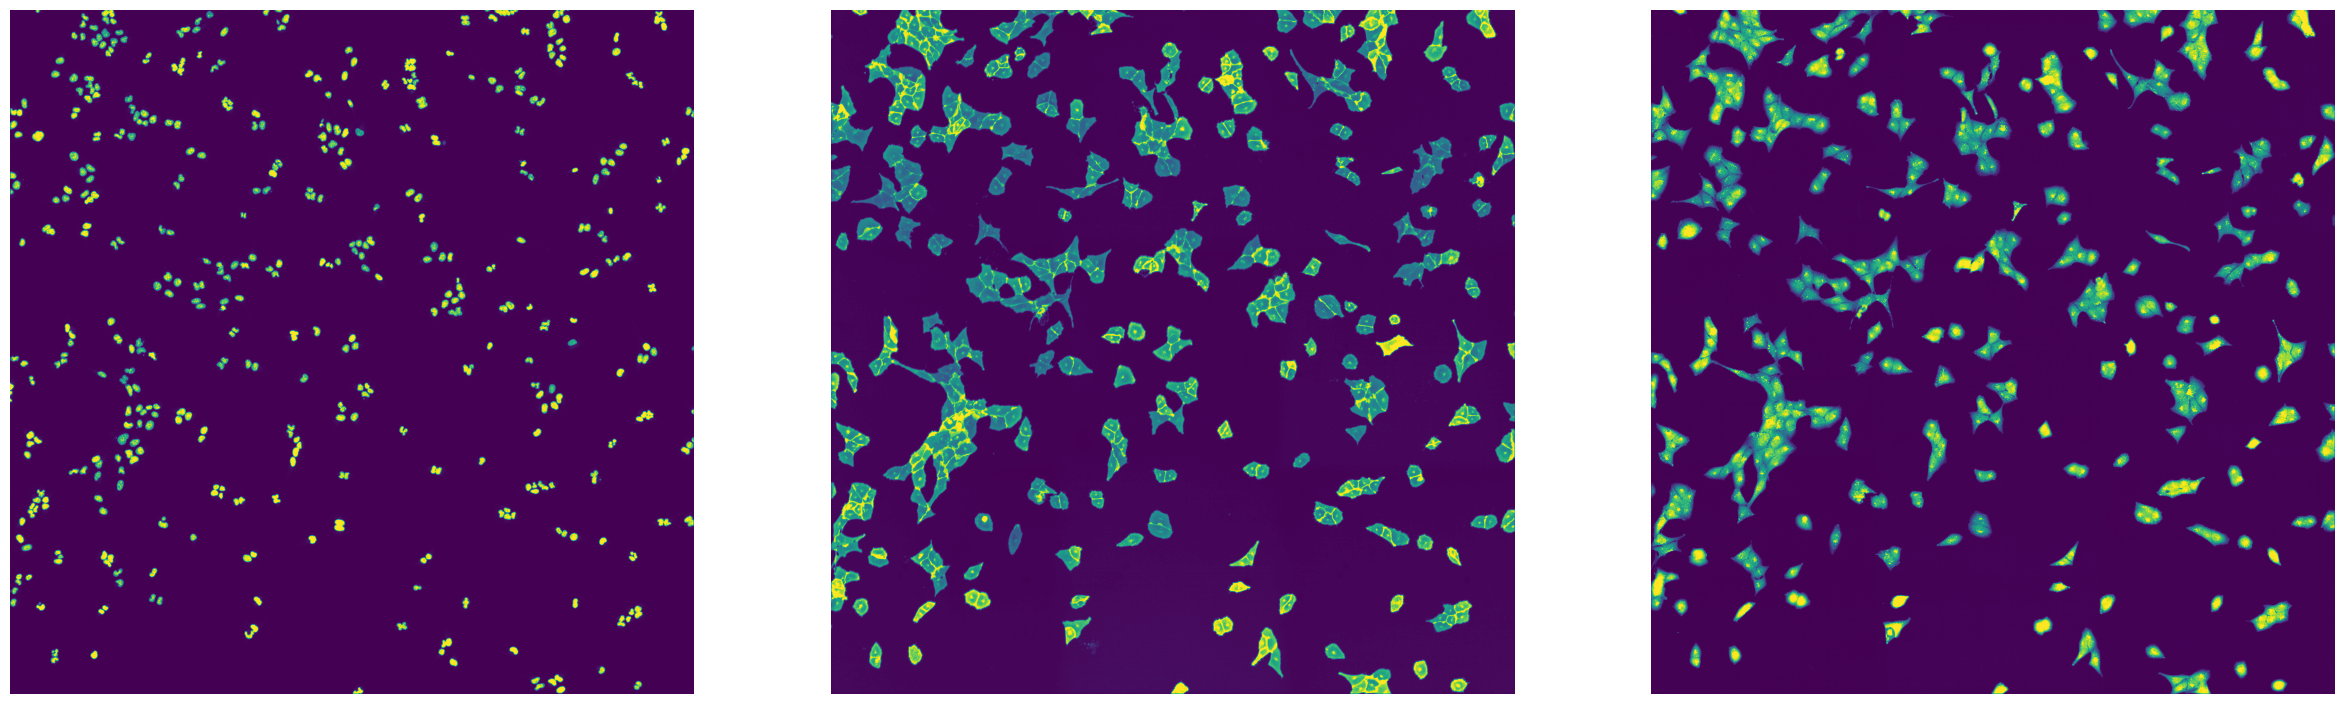

In [18]:
import matplotlib.pyplot as plt
from tifffile import imread

fig, axs = plt.subplots(1, 3, figsize=(30, 10))
axs[0].imshow(imread(f"{outdir_parallel}/stitching_test_parallel_Alexa488.tif"))
axs[0].axis("off")

axs[1].imshow(imread(f"{outdir_parallel}/stitching_test_parallel_DAPI.tif"))
axs[1].axis("off")

axs[2].imshow(imread(f"{outdir_parallel}/stitching_test_parallel_mCherry.tif"))
axs[2].axis("off")

The results generated from a parallelized vs a single-threaded run are identical. 

In [19]:
# compare parallel and non-parallel stitching

imread(f"{outdir_parallel}/stitching_test_parallel_Alexa488.tif") == imread(f"{outdir}/stitching_test_Alexa488.tif")

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True, False, False, ..., False, False,  True],
       [ True, False, False, ..., False, False,  True],
       ...,
       [ True, False, False, ..., False, False,  True],
       [ True, False, False, ..., False, False,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [20]:
del stitcher